In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.io import read_image

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

from PIL import Image
import os
import cv2
import numpy as np

In [2]:
COLOR_PATH_TRAIN = "/data/fd2135/imagenet/ILSVRC/Data/DET/train/ILSVRC2013_train/n01530575"
SKETCH_PATH_TRAIN = "/data/fd2135/imagenet/ILSVRC/Data/DET/train/ILSVRC2013_train_sketch/n01530575"
COLOR_PATH_TEST = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/test"
SKETCH_PATH_TEST = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/test_sketch"
COLOR_PATH_VAL = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/val"
SKETCH_PATH_VAL = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/val_sketch"

In [3]:
from torchvision.io.image import ImageReadMode
from torchvision.transforms.functional import resize
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize

resizer=Resize([256,256])

class CustomImageDataset(Dataset):
    def __init__(self, sketch_dir, color_dir, transform=None, target_transform=None):
        self.sketch_dir = sketch_dir
        self.color_dir = color_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dirs=os.listdir(sketch_dir)

    def __len__(self):
        #return len(self.dirs)
        return 20

    def __getitem__(self, idx):
        file_name=self.dirs[idx]
        sketch_path = os.path.join(self.sketch_dir, file_name)
        sketch_image = read_image(sketch_path, ImageReadMode.GRAY)
        sketch_image=resizer(sketch_image)

        color_path = os.path.join(self.color_dir, file_name)
        color_image = read_image(color_path, ImageReadMode.RGB)
        color_image=resizer(color_image)

        if self.transform:
            sketch_image = self.transform(sketch_image)
        if self.target_transform:
            color_image = self.target_transform(color_image)
        return sketch_image, color_image

In [4]:
from torch.utils.data import DataLoader
test_data = CustomImageDataset(
    SKETCH_PATH_TRAIN,
    COLOR_PATH_TRAIN,
    transform=None,
    target_transform=None
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
import torch
from torch import nn

class BaseColor(nn.Module):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.

    def normalize_l(self, in_l):
        return (in_l-self.l_cent)/self.l_norm

    def unnormalize_l(self, in_l):
        return in_l*self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab/self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm

In [6]:
import torch
import torch.nn as nn
import numpy as np
from IPython import embed

class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 3, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')
        

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))
        

        return self.unnormalize_ab(self.upsample4(out_reg))

In [7]:
model=ECCVGenerator()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

<ipython-input-75-6799d8ac9431>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-75-6799d8ac9431>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


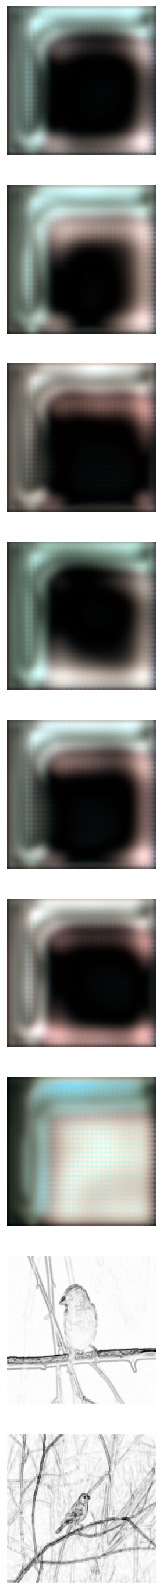

5005.75830078125

In [75]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    
    #model.eval()
    with torch.no_grad():
        
        for (x, y) in iterator:
            

            
            x_imgg=x.detach().numpy()
            

            
            #plt.figure(figsize=(256*10, 256))
            #for index, image in enumerate(x_img):
            #    im=image.squeeze()
            #    plt.subplot(256, 256, index+1)
            #    plt.imshow(im, cmap="gray")
            #    plt.axis("off")
            #plt.show()
            
            #x_img=x_img[13].squeeze()
            #x_img=np.swapaxes(x_img,0,1)
            #x_img=np.swapaxes(x_img,1,2)
            
            #plt.imshow(x_img, cmap="gray")
            #plt.show()
            
            
            y_imgg=y.detach().numpy()
            
            
            
            
            #y_img=y_img[13]
            #y_img=np.swapaxes(y_img,0,1)
            #y_img=np.swapaxes(y_img,1,2)
            
            #plt.imshow(y_img)
            #plt.show()
            
            
            x_data = torch.tensor(x, dtype=torch.float32)/255
            y_data = torch.tensor(y, dtype=torch.float32)/255
            
            
            y_pred = model(x_data)
            
            bd=y_pred.detach().numpy()
            

            
            plt.figure(figsize=(29, 29))
            #plt.figure()
            plt.subplot(911)
            c=bd[14]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")

            plt.subplot(912)
            c=bd[16]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            plt.subplot(913)
            c=bd[19]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            
            plt.subplot(914)
            c=bd[2]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            
            plt.subplot(915)
            c=bd[3]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            
            plt.subplot(916)
            c=bd[6]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            
            plt.subplot(917)
            c=bd[8]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255
            plt.imshow(c.astype(int))
            plt.axis("off")
            
            
            plt.subplot(918)
            x_img=x_imgg[9].squeeze()
            plt.imshow(x_img, cmap="gray")
            plt.axis("off")
            
            
            plt.subplot(919)
            x_img=x_imgg[10].squeeze()
            plt.imshow(x_img, cmap="gray")
            plt.axis("off")
            
            plt.show()
            
            #print(y_pred.size())
            #print(bd)
            #c=bd[13]
            #c=np.swapaxes(c,0,1)
            #c=np.swapaxes(c,1,2)
            
            #plt.imshow(c)
            #plt.show()
            
            #c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            #c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            #c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255

            #plt.imshow(c.astype(int))
            #plt.show()

            loss = criterion(y_pred, y_data)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

m=(torch.load('net_14.pth'))

evaluate(m,test_dataloader, criterion, device)

In [9]:
m=(torch.load('net_13.pth'))

#imgd = train_features[0].squeeze()
#labeld = train_labels[0]
#plt.imshow(imgd, cmap="gray")
#plt.show()
#labeld=np.swapaxes(labeld,0,1)
#labeld=np.swapaxes(labeld,1,2)
#plt.imshow(labeld)
#plt.show()

#a=torch.tensor(np.swapaxes(train_data[999][0].astype(np.float32)/255,0,2))
#cv2_imshow(train_data[999][0])
#print(len(train_data[999][0][0]))
#print(train_data[5][0])
#print(a.size())
test_pred = m(test_dataloader)

bd=test_pred.detach().numpy()
print(test_pred.size())
#bd=np.swapaxes(bd,0,1)
#bd=np.swapaxes(bd,1,2)
print(bd)

plt.imshow(bd)
plt.show()
#print(len(b[:][0]))
#print(bd[:,:,1].max())
#bd=(bd*255)
#cv2_imshow(b.astype(int))

#b=b/255

#bd[:,:,1]=(bd[:,:,1]-bd[:,:,1].min())/(bd[:,:,1].max()-bd[:,:,1].min())*255
#bd[:,:,0]=(bd[:,:,0]-bd[:,:,0].min())/(bd[:,:,0].max()-bd[:,:,0].min())*255
#bd[:,:,2]=(bd[:,:,2]-bd[:,:,2].min())/(bd[:,:,2].max()-bd[:,:,2].min())*255

#plt.imshow(bd)

#c=train_data[50][1]
#cv2_imshow(b[:,:,1].astype(int))
#cv2_imshow(b[:,:,0].astype(int))
#cv2_imshow(b[:,:,2].astype(int))
#cv2_imshow(b.astype(int))

TypeError: unsupported operand type(s) for -: 'DataLoader' and 'float'

In [ ]:
c=bd[13]
            c=np.swapaxes(c,0,1)
            c=np.swapaxes(c,1,2)
            
            #plt.imshow(c)
            #plt.show()
            
            c[:,:,1]=(c[:,:,1]-c[:,:,1].min())/(c[:,:,1].max()-c[:,:,1].min())*255
            c[:,:,0]=(c[:,:,0]-c[:,:,0].min())/(c[:,:,0].max()-c[:,:,0].min())*255
            c[:,:,2]=(c[:,:,2]-c[:,:,2].min())/(c[:,:,2].max()-c[:,:,2].min())*255

In [ ]:
            plt.figure(figsize=(29, 29))
            #plt.figure()
            plt.subplot(911)
            y_img=y_imgg[14].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")

            plt.subplot(912)
            y_img=y_imgg[16].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            plt.subplot(913)
            y_img=y_imgg[19].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            
            plt.subplot(914)
            y_img=y_imgg[2].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            
            plt.subplot(915)
            y_img=y_imgg[3].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            
            plt.subplot(916)
            y_img=y_imgg[6].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            
            plt.subplot(917)
            y_img=y_imgg[8].squeeze()
            y_img=np.swapaxes(y_img,0,1)
            y_img=np.swapaxes(y_img,1,2)
            plt.imshow(y_img)
            plt.axis("off")
            
            
            plt.subplot(918)
            x_img=x_imgg[9].squeeze()
            plt.imshow(x_img, cmap="gray")
            plt.axis("off")
            
            
            plt.subplot(919)
            x_img=x_imgg[10].squeeze()
            plt.imshow(x_img, cmap="gray")
            plt.axis("off")
            
            plt.show()